Visualisieren:
../../libMultiRobotPlanning-master/example/visualize.py test.yaml output.yaml


Basic Info:
[North, East, South, West]
DO_NOTHING= 0 MOVE_FORWARD= 2 MOVE_LEFT= 1 MOVE_RIGHT= 3 STOP_MOVING= 4

In [1]:
import sys
import time
from typing import Optional, List, Dict
import PIL
import yaml
import subprocess

import numpy as np

from flatland.core.env import Environment
from flatland.core.env_observation_builder import ObservationBuilder
from flatland.core.grid.grid_utils import coordinate_to_position
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.utils.rendertools import RenderTool
from flatland.core.grid.grid4_utils import get_new_position
from flatland.envs.rail_generators import rail_from_file
from flatland.envs.malfunction_generators import MalfunctionParameters, ParamMalfunctionGen

np.random.seed(100)

direction_to_str = {-1 : "pass...", 0: "North", 1: "East", 2: "South", 3: "West"}
action_to_str = {-1 : "pass...", 0 : "Do nothing", 1: "Left", 2 : "Forward", 3 : "Right", 4 : "Stop moving"}

In [9]:
# 3, 2, 2, 20, 20, agents 5

render = True
print_more_info = False

try:

    """
    rail_generator=sparse_rail_generator(
        max_num_cities = 3,
        grid_mode= False,
        max_rails_between_cities = 2,
        max_rails_in_city = 2, 
        seed=0
    )
    
    env = RailEnv(
        width=20, height=20,
        rail_generator=rail_generator,
        schedule_generator=sparse_schedule_generator(),
        number_of_agents=6
    )
    
    obs, info = env.reset()
    
    
    # Just do one dummy step so the Trains get a Position. My assumtion is, that it is always the same
    env.step({i : 2 for i in range(env.get_num_agents())})
    env.step({i : 2 for i in range(env.get_num_agents())})
    env.step({i : 2 for i in range(env.get_num_agents())})
    env.step({i : 2 for i in range(env.get_num_agents())})
    """

    print("Start searching...")
    
    res = get_scheudueles(env)
    print("Searching end!")

    # For rendering the Environment and the steps done by the agents
    if render: 
        env_renderer = RenderTool(env, screen_width=2000, screen_height=2000)
        env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=False)
    
    # Empty action dictionary which has the predicted actions in it for each step
    action_dict = dict()
    
    # For Loop with all the steps predicted by the agent
    for step in range(1000):
        
        for handle in range(env.get_num_agents()):
        
            actions = res[handle]
            
            if not actions.is_empty() and info['action_required'][handle]:
                action_dict[handle] = actions.pop(0)

            else:
                action_dict[handle] = 0
        
        # Do the actual step in the Enviroment based on the action_dict computed previously 
        obs, all_rewards, done, info = env.step(action_dict)
        
        # Print the current status of the agents in each iteration
        print(f"[{step+1:3}] In goal: {[handle for handle, status in done.items() if status]}")
        
        if print_more_info:
            print("Iteration:", step)
            for handle, action in action_dict.items():
                print(f"<{handle}> Action: |{action}|, Position: {env.agents[handle].position}, Target: {env.agents[handle].target}, Direction: {direction_to_str[env.agents[handle].direction]}")

        if render: 
            env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=False)
            time.sleep(.5)

        if done["__all__"]:
            print(f"\nAll Agents are in their targets! After {step+1} iterations.")
            break
            
finally:
    if render : env_renderer.close_window()


Start searching...
Searching end!
open_window - pyglet
[  1] In goal: []
[  2] In goal: []
[  3] In goal: []
[  4] In goal: []
[  5] In goal: []
[  6] In goal: []
[  7] In goal: []
[  8] In goal: []
[  9] In goal: []
[ 10] In goal: []
[ 11] In goal: []
[ 12] In goal: []
[ 13] In goal: []
[ 14] In goal: []
[ 15] In goal: []
[ 16] In goal: []
[ 17] In goal: []
[ 18] In goal: []
[ 19] In goal: []
[ 20] In goal: []
[ 21] In goal: []
[ 22] In goal: [6]
[ 23] In goal: [6]
[ 24] In goal: [4, 6]
[ 25] In goal: [3, 4, 6, 7]
[ 26] In goal: [2, 3, 4, 6, 7]
[ 27] In goal: [2, 3, 4, 6, 7, 8]
[ 28] In goal: [2, 3, 4, 6, 7, 8]
[ 29] In goal: [2, 3, 4, 6, 7, 8]
[ 30] In goal: [2, 3, 4, 6, 7, 8]
[ 31] In goal: [2, 3, 4, 6, 7, 8]
[ 32] In goal: [2, 3, 4, 6, 7, 8]
[ 33] In goal: [1, 2, 3, 4, 6, 7, 8]
[ 34] In goal: [1, 2, 3, 4, 6, 7, 8]
[ 35] In goal: [1, 2, 3, 4, 6, 7, 8]
[ 36] In goal: [0, 1, 2, 3, 4, 5, 6, 7, 8, '__all__']

All Agents are in their targets! After 36 iterations.


In [2]:
class ActionList:
    def __init__(self, actions):
        self.actions = actions
        
    def pop(self, n=0):
        # If the list is emmpty and there is no more to do, just return the wait action
        if len(self.actions) == 0:
            return 4
        
        return self.actions.pop(n)
    
    def is_empty(self):
        return len(self.actions) == 0
    
    def __repr__(self):
        return str(self.actions)
    

def get_scheudueles(env, outfilename="out.yaml"):
    
    # Create the file with all the actions by each agent
    grid_actions = get_grid_actions(env)
    
    # Get the grid to compute the heuristics later on
    grid = get_grid(env)
    
    # Run the C++ file with the created 
    subprocess.run(["./../../libMultiRobotPlanning-master/build/cbs", "-i", grid_actions, "-g", grid, "-o", outfilename], check=True)

    # ../../libMultiRobotPlanning-master/build/output.yaml
    with open("../../libMultiRobotPlanning-master/build/output.yaml") as output_file:
          yaml_out = yaml.load(output_file, Loader=yaml.FullLoader)


    action_dict = dict()
    for handle, agent in enumerate(yaml_out["schedule"]):
        action_dict[handle] = ActionList(yaml_out["schedule"][str(agent)])
        
        
    return action_dict
        


# action_dict = get_scheudueles(env)


In [2]:
def render_env(env):
    env_renderer = RenderTool(env, gl="PILSVG", screen_width=5000, screen_height=5000, show_debug=True)

    for i in range(env.get_num_agents()):
        
        if i == 1:
            env.dev_obs_dict[i] = []
    
        else:
            env.dev_obs_dict[i] = []
    
    
    
    env_renderer.render_env(show=True, frames=False, show_observations=True, show_predictions=False, show_rowcols=True)

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    display(pil_image)

render_env(env)

NameError: name 'env' is not defined

In [9]:
for a in env.agents:
    print(a.handle, a.position)

0 (18, 18)
1 (12, 15)
2 (17, 19)
3 (15, 23)
4 (14, 2)
5 (12, 14)
6 (17, 16)
7 (13, 6)
8 (19, 8)


In [130]:
lst = [(29, 36), (28, 36), (27, 36), (26, 36), (25, 36), (24, 36), (23, 36), (23, 37), (22, 37), (21, 37), (20, 37), (19, 37), (18, 37), (17, 37), (17, 38), (17, 39), (17, 40), (17, 41), (17, 42), (17, 43), (17, 44), (17, 45), (17, 46), (17, 47), (16, 47), (15, 47), (14, 47), (13, 47), (12, 47), (12, 46), (12, 45), (12, 44), (12, 43), (12, 42), (12, 41), (12, 40), (12, 39), (12, 38), (12, 37), (12, 36), (13, 36), (14, 36), (15, 36), (16, 36), (16, 35), (16, 34), (16, 33), (16, 32), (16, 31), (16, 30), (16, 29), (16, 28), (16, 27), (16, 26), (16, 25), (16, 24), (16, 23), (16, 22), (16, 21), (16, 20), (16, 19), (16, 18), (15, 18), (15, 17), (15, 16), (15, 15), (15, 14), (16, 14), (17, 14), (18, 14), (19, 14), (20, 14), (21, 14), (22, 14)]
lst.reverse()

for n, i in enumerate(lst):
    if i == (27, 36): print(n)

71


In [ ]:
# 0 rot
# 4 blau links
# 8 türkis

In [9]:
from flatland.envs.schedule_generators import schedule_from_file

In [3]:
def set_speed(env, speed_ration_map):

    for a in env.agents:
        a.speed_data['speed'] = np.random.choice(list(speed_ration_map.keys()), p=list(speed_ration_map.values()))

speed_ration_map = {1.: .0,
                            1. / 2.: 0.,
                            1. / 3.: 1.,
                            1. / 4.: 0.}

stochastic_data = MalfunctionParameters(
                  malfunction_rate=1/4,
                  min_duration=3,
                  max_duration=4
        )

{'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.READY_TO_DEPART: 0>}}

[0]
{'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 0.3333333333333333}, 'status': {0: <RailAgentStatus.READY_TO_DEPART: 0>}}
{0: False, '__all__': False}

Agent 0:
{'position_fraction': 0.0, 'speed': 0.3333333333333333, 'transition_action_on_cellexit': 0.0}
{'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0, 'moving_before_malfunction': False}
True

[1]
{'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 0.3333333333333333}, 'status': {0: <RailAgentStatus.READY_TO_DEPART: 0>}}
{0: False, '__all__': False}

Agent 0:
{'position_fraction': 0.0, 'speed': 0.3333333333333333, 'transition_action_on_cellexit': 0.0}
{'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0, 'moving_before_malfunction': False}
True

[2]
{'action_required': {0: True}, 'malfunction': {0: 0

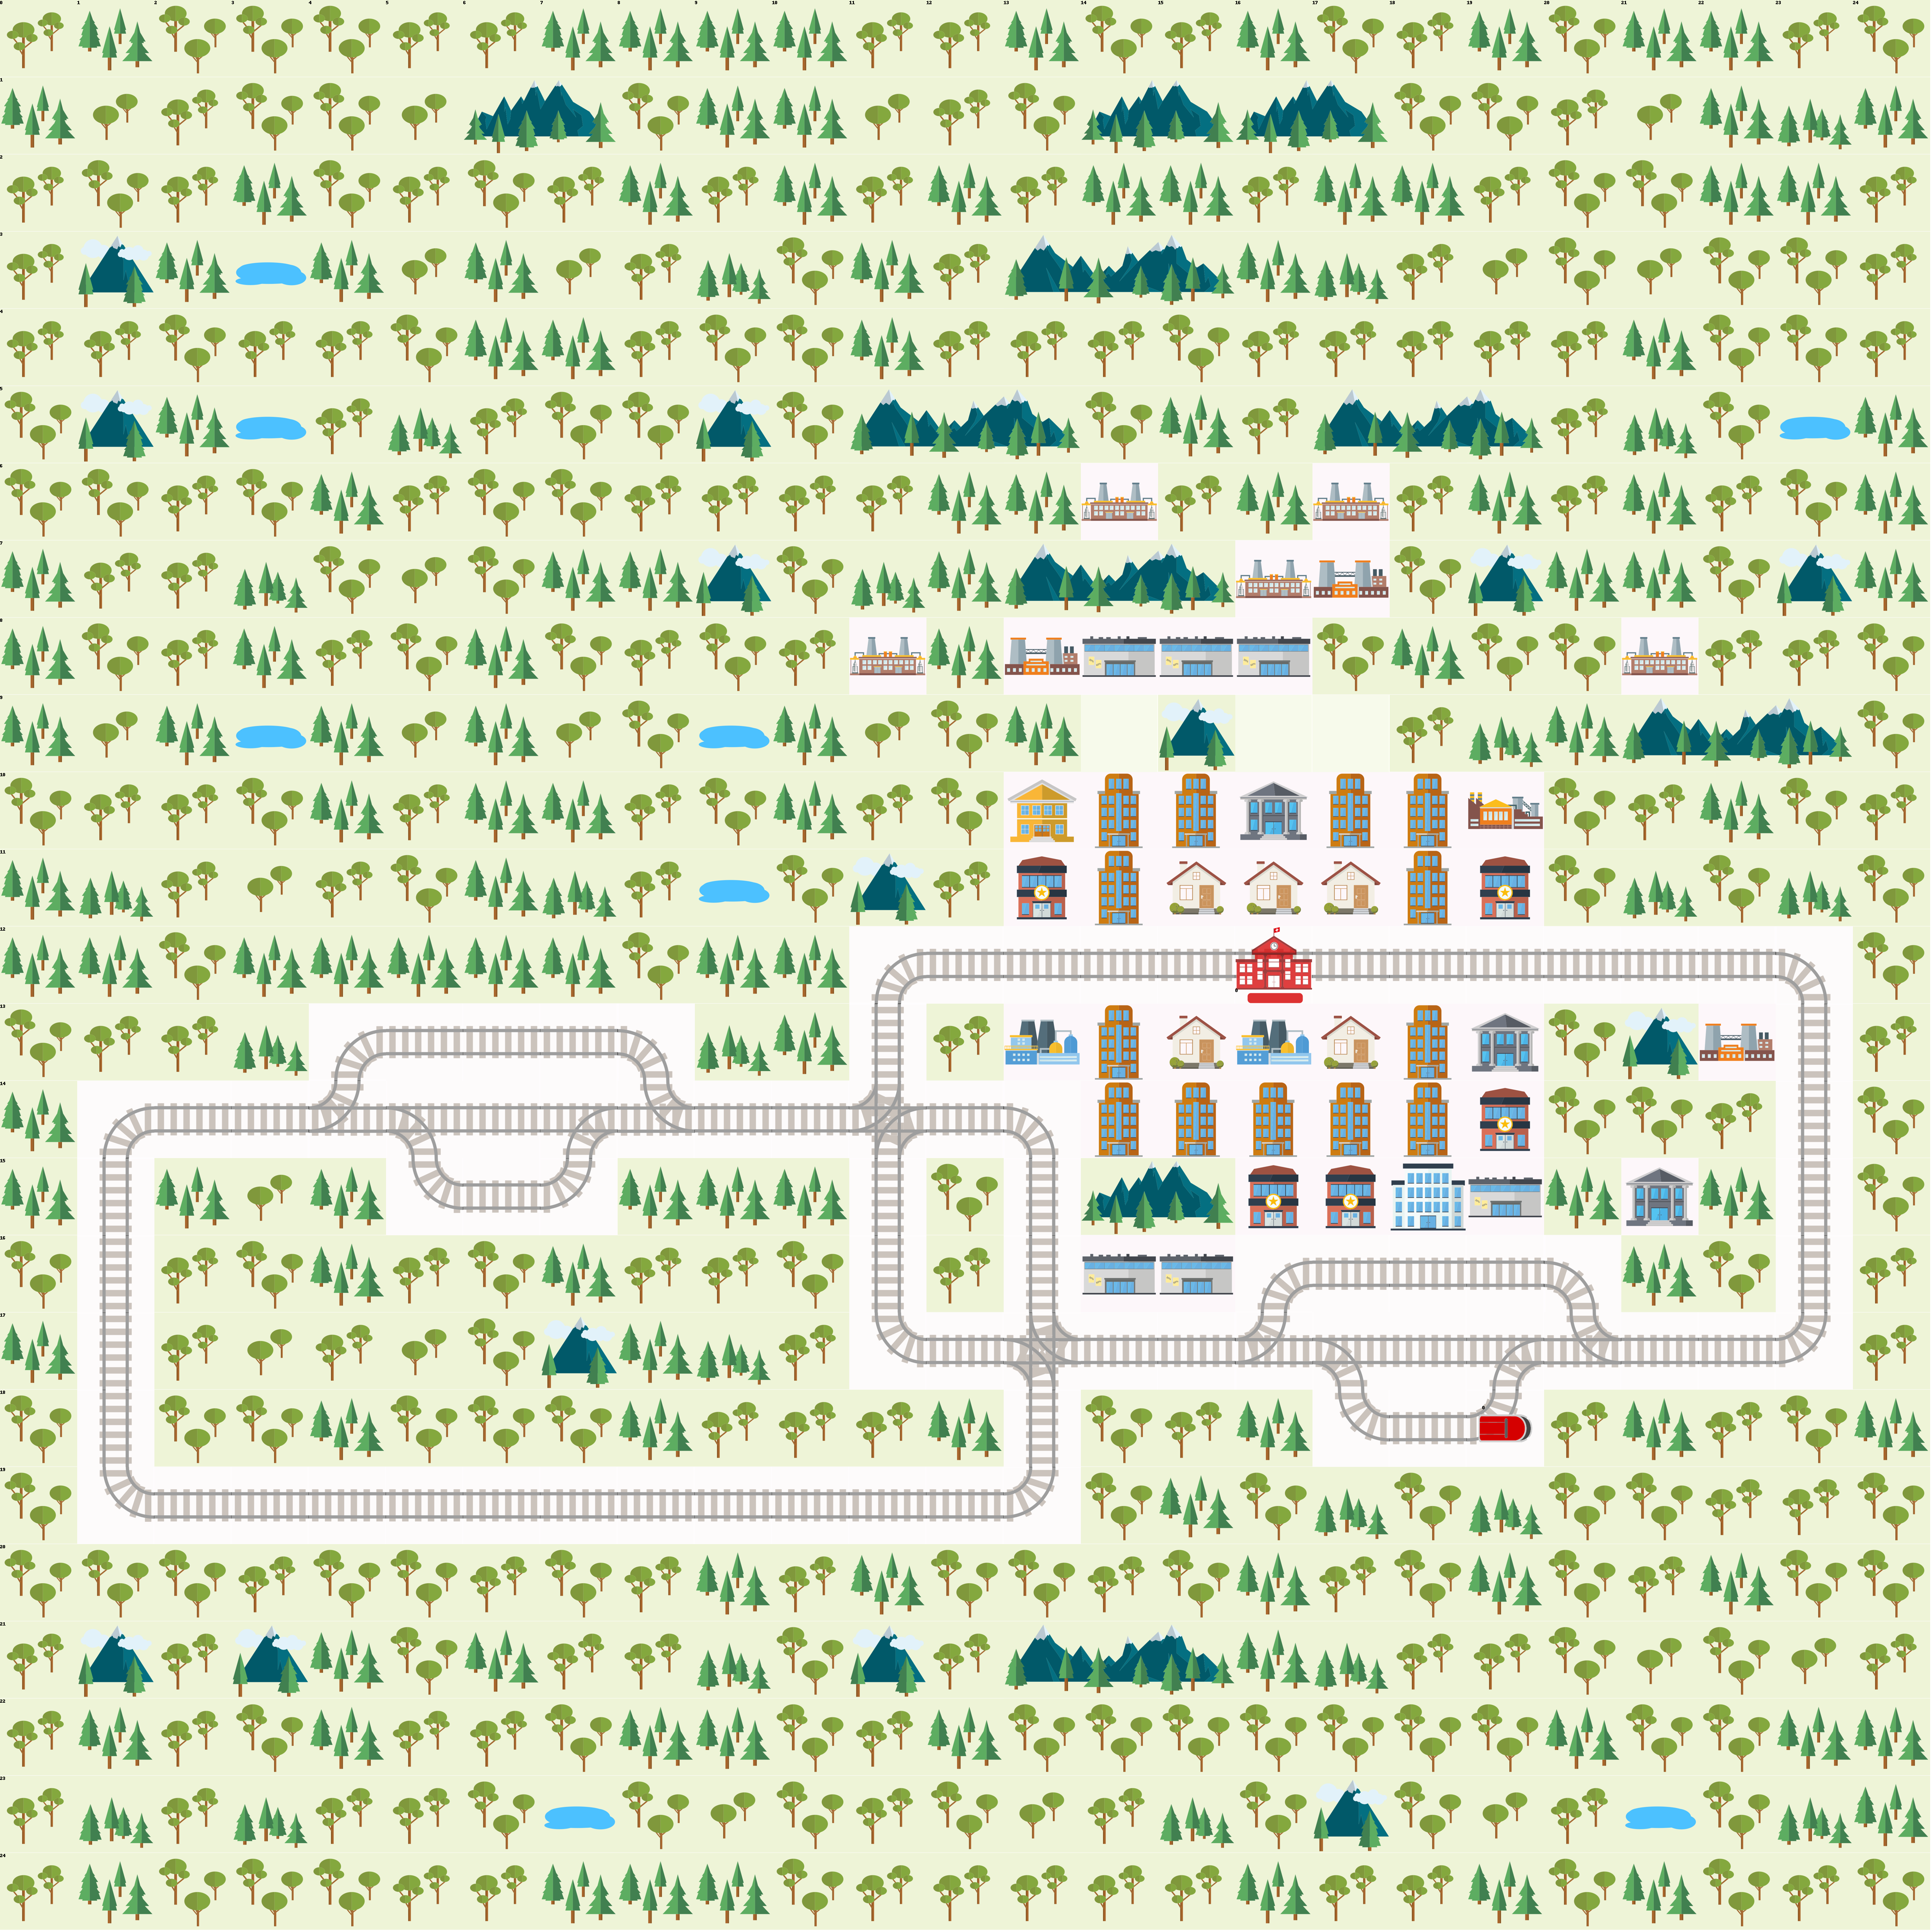

In [13]:

env = RailEnv(
        width=0,
        height=0,
        rail_generator=rail_from_file("../scratch/test-envs/Test_6/Level_0.pkl"),
        number_of_agents=1,
        #malfunction_generator=ParamMalfunctionGen(stochastic_data)
    )


_, info = env.reset()
set_speed(env, speed_ration_map)
print(info)


for step in range(6):
    print(f"\n[{step}]")
    
    if step == 0:
        _, _, done, info = env.step({i : 4 for i in range(env.get_num_agents())})
    else:
        _, _, done, info = env.step({i : 4 for i in range(env.get_num_agents())})

    print(info)
    print(done)
    for handle, a in enumerate(env.agents):
        print(f"\nAgent {handle}:")
        print(a.speed_data)
        print(a.malfunction_data)
        print(env.action_required(a))

for step in range(4):
    _, _, done, info = env.step({i : 2 for i in range(env.get_num_agents())})

    print(info)
    print(done)
    for handle, a in enumerate(env.agents):
        print(f"\nAgent {handle}:")
        print(a.speed_data)
        print(a.malfunction_data)
        print(env.action_required(a))
        
_, _, done, info = env.step({i : 2 for i in range(env.get_num_agents())})

print(info)
print(done)
for handle, a in enumerate(env.agents):
    print(f"\nAgent {handle}:")
    print(a.speed_data)
    print(a.malfunction_data)
    print(env.action_required(a))
    

render_env(env)


    

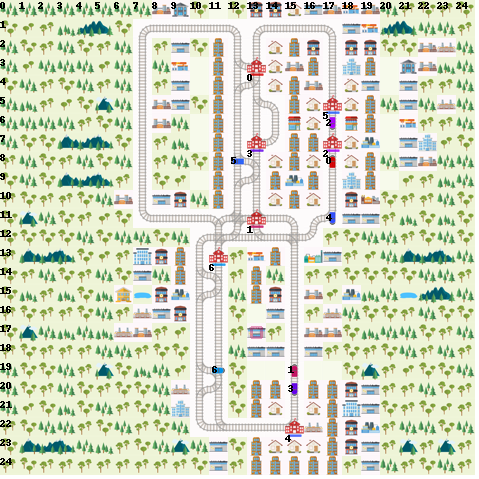

In [532]:
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

stochastic_data = MalfunctionParameters(
                  malfunction_rate=1/100,
                  min_duration=3,
                  max_duration=10
        )


env = RailEnv(width=50,
              height=50,
              rail_generator=rail_from_file("../scratch/test-envs/Test_5/Level_0.pkl"),
              malfunction_generator=ParamMalfunctionGen(stochastic_data),
              number_of_agents=7,
              remove_agents_at_target=True,
              record_steps=True
              )


_, info = env.reset()

for a in env.agents:
    a.speed_data['speed'] = np.random.choice(list(speed_ration_map.keys()), p=list(speed_ration_map.values()))

for _ in range(1):
    env.step({i : 2 for i in range(env.get_num_agents())})


render_env(env)

In [25]:
env.agents[0]

EnvAgent(initial_position=(18, 8), initial_direction=0, direction=0, target=(22, 10), moving=False, speed_data={'position_fraction': 0.0, 'speed': 0.3333333333333333, 'transition_action_on_cellexit': 0.0}, malfunction_data={'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0, 'moving_before_malfunction': False}, handle=0, status=<RailAgentStatus.ACTIVE: 1>, position=(18, 8), old_direction=None, old_position=None)

(0, 0, 0, 0)

In [524]:
def own_test(filename):

    def generator(rail: GridTransitionMap, num_agents: int, hints: Any = None, num_resets: int = 0,
                  np_random: RandomState = None) -> Schedule:

        env_dict = persistence.RailEnvPersister.load_env_dict(filename)
        
        max_episode_steps = env_dict.get("max_episode_steps", 0)
        if (max_episode_steps==0):
            print("This env file has no max_episode_steps (deprecated) - setting to 100")
            max_episode_steps = 100
        
        
        agents = env_dict["agents"]
        
        agents_position = [a.initial_position for a in agents]
        agents_direction = [a.initial_direction for a in agents]
        agents_target = [a.target for a in agents]
        agents_speed = [a.speed_data['speed'] for a in agents]
        
        print(agents_speed)
        agent_malfunction_rates = [1.0 for a in agents]
        
        return Schedule(agent_positions=agents_position, agent_directions=agents_direction,
                        agent_targets=agents_target, agent_speeds=agents_speed, agent_malfunction_rates=None,
                        max_episode_steps=max_episode_steps)


    

    return generator

In [445]:

for a in env.agents:
    a.speed_data['speed'] = np.random.choice(list(speed_ration_map.keys()), p=list(speed_ration_map.values()))

In [182]:
from typing import Callable, NamedTuple, Optional, Tuple
Malfunction = NamedTuple('Malfunction', [('num_broken_steps', int)])

{'position_fraction': 0.5, 'speed': 0.5, 'transition_action_on_cellexit': 2}
{'position_fraction': 0.0, 'speed': 1.0, 'transition_action_on_cellexit': <RailEnvActions.DO_NOTHING: 0>}
{'position_fraction': 0.5, 'speed': 0.5, 'transition_action_on_cellexit': 2}


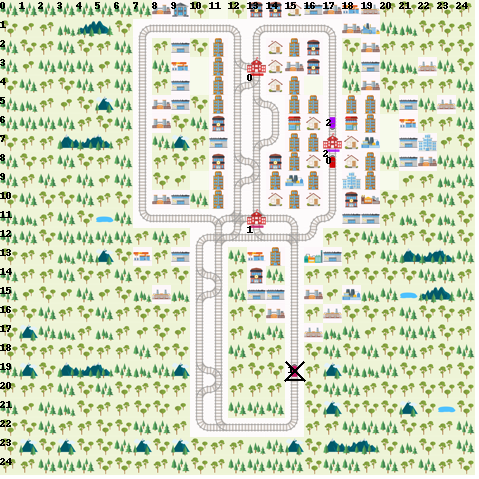

In [527]:
env.step({i : 2 for i in range(env.get_num_agents())})

for a in env.agents:
    print(a.speed_data)

render_env(env)

In [16]:
env.distance_map.get()[0]

array([[[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        ...,
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]],

       [[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        ...,
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]],

       [[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        ...,
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]],

       ...,

       [[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        ...,
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]],

       [[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        ...,
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]],

       [[inf

In [53]:
class NextCell():
    
    def __init__(self, position, action, direction):
        self.position = position
        self.action = action
        self.direction = direction

    def __repr__(self):
        return f"{self.position} | {action_to_str[self.action]} | {direction_to_str[self.direction]}"


# Position, action, cost, direction
def calc_next_cell(position, direction):            
    
    possible_transitions = env.rail.get_transitions(*position, direction)

    # This should be never true when searching with the a star algorithm
    if all(d == 0 for d in possible_transitions):
        # print("This Direction is not permissable!")
        return -1
    
    # Initalize the next_cells with the action when there is done nothing/waiting (4), because this is alway possible
    next_cells = []

    # Loop trough all the possible dirrections the agent can reach from current direction
    for d in [(direction + i) % 4 for i in range(-1, 2)]:
        
        if possible_transitions[d]:
            
            # Die neue Position, wenn man die jeweilige direction 
            new_position = get_new_position(position, d)
            
            # Check the given directions and map it to the corresponding action
            if d == direction:
                next_cells.append(NextCell(new_position, 2, d))

            elif (d + 1) % 4 == direction:
                next_cells.append(NextCell(new_position, 1, d))
                
            elif (d - 1) % 4 == direction:
                next_cells.append(NextCell(new_position, 3, d))
    
    else:
    
        # Check if the transition is an dead End
        if possible_transitions[(direction + 2) % 4] == 1:
            direction = (direction + 2) % 4

            new_position = get_new_position(position, direction)

            next_cells.append(NextCell(new_position, 2, direction))
    
    return next_cells

In [7]:
def calc_coord(position):
    return [int(position[0]) , int(position[1])]


# This function is for creating the actions each agent can do in a certain cell
def get_grid_actions(env, filename="grid_actions.yaml"):
    env_map = env.distance_map.get()
    
    
    all_agents = []
    for handle, a in enumerate(env.agents):
        agent = {"goal" : calc_coord(a.target), "name" : "agent" + str(handle), "start" : calc_coord(a.position), "direction" : int(a.direction)}

        all_agents.append(agent)


    edges = []
    critcal = []
    for y in range(env.height):
        for x in range(env.width):
            if True in env.get_valid_directions_on_grid(y, x):

                position = (y, x)

                for direction in range(0, 4):
                    res = calc_next_cell(position, direction)

                    if res == -1:
                        continue

                    for new_pos in res:
                        edge = {"from" : calc_coord(position), "direction" : direction, "to" : calc_coord(new_pos.position), "action" : new_pos.action, "new_direction" : new_pos.direction}
                        edges.append(edge)

                
                # Check the critical positions
                for handle in range(env.get_num_agents()):
                    if np.count_nonzero(env_map[handle, y, x] == np.inf) < 2:
                        critcal.append(calc_coord(position))
                        break


    res_dict = {"agents" : all_agents, "map" : {"dimensions" : [env.height, env.width], "edges" : edges, "critical" : critcal}}

    f = open(filename, "w")
    yaml.dump(res_dict, f)
    f.close()
    
    return filename
    
    
# This function is for generating the grid of the map, which is then passed to the C++ file
def get_grid(env, filename="grid.txt"):
    
    res = ""
    np_shape = env.distance_map.get().shape
    env_map = env.distance_map.get()

    for handle in range(env.get_num_agents()):
        for y in range(np_shape[1]):
            for x in range(np_shape[2]):
                for value in list(env_map[handle, y, x]):

                    if value == np.inf:
                        res += str(-1) + " "
                    else:
                        res += str(int(value)) + " "

    f = open(filename, "w")
    f.write(str([int(i) for i in np_shape]) + "\n")
    f.write(res)
    f.close()
    
    return filename


# This function is for creating the map, which can then passed to the visualizer
def get_grid_python_visualization(env, filename="visualize_map.yaml"):
    agents = []

    for handle, a in enumerate(env.agents):
        agent = {"goal" : calc_coord(a.target), "name" : "agent" + str(handle), "start" : calc_coord(a.initial_position)}

        agents.append(agent)


    obstacles = []
    for y in range(env.width):
        for x in range(env.height):
            if not True in env.get_valid_directions_on_grid(x, y):
                obstacles.append(calc_coord((x, y)))

    res_dict = {"agents" : agents, "map" : {"dimensions" : [env.height, env.width], "obstacles" : obstacles}}


    f = open(filename, "w")
    yaml.dump(res_dict, f)
    f.close()
    
    return filename
    
get_grid_actions(env)
get_grid(env)

'grid.txt'

In [60]:
env.distance_map.get()

array([[[[inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         ...,
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf]],

        [[inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         ...,
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf]],

        [[inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         ...,
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf]],

        ...,

        [[inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         ...,
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf]],

        [[inf, inf, inf, inf],
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         ...,
         [inf, inf, inf, inf],
         [inf, inf, inf, inf],
         

In [82]:
from flatland.envs.rail_generators import rail_from_file
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

In [93]:


tst = 

{'action_required': {0: True, 1: True, 2: True, 3: True, 4: True, 5: True, 6: True, 7: True, 8: True, 9: True, 10: True}, 'malfunction': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}, 'speed': {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}, 'status': {0: <RailAgentStatus.READY_TO_DEPART: 0>, 1: <RailAgentStatus.READY_TO_DEPART: 0>, 2: <RailAgentStatus.READY_TO_DEPART: 0>, 3: <RailAgentStatus.READY_TO_DEPART: 0>, 4: <RailAgentStatus.READY_TO_DEPART: 0>, 5: <RailAgentStatus.READY_TO_DEPART: 0>, 6: <RailAgentStatus.READY_TO_DEPART: 0>, 7: <RailAgentStatus.READY_TO_DEPART: 0>, 8: <RailAgentStatus.READY_TO_DEPART: 0>, 9: <RailAgentStatus.READY_TO_DEPART: 0>, 10: <RailAgentStatus.READY_TO_DEPART: 0>}}


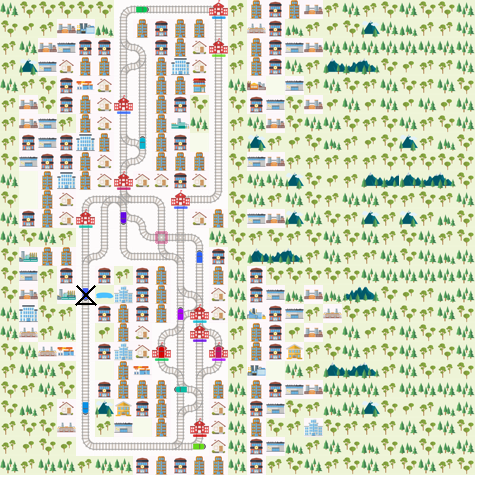

{'action_required': {0: True,
  1: True,
  2: True,
  3: True,
  4: True,
  5: True,
  6: True,
  7: True,
  8: True,
  9: True,
  10: True},
 'malfunction': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 11,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0},
 'speed': {0: 1.0,
  1: 1.0,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0},
 'status': {0: <RailAgentStatus.ACTIVE: 1>,
  1: <RailAgentStatus.ACTIVE: 1>,
  2: <RailAgentStatus.ACTIVE: 1>,
  3: <RailAgentStatus.ACTIVE: 1>,
  4: <RailAgentStatus.ACTIVE: 1>,
  5: <RailAgentStatus.ACTIVE: 1>,
  6: <RailAgentStatus.ACTIVE: 1>,
  7: <RailAgentStatus.ACTIVE: 1>,
  8: <RailAgentStatus.ACTIVE: 1>,
  9: <RailAgentStatus.ACTIVE: 1>,
  10: <RailAgentStatus.ACTIVE: 1>}}

In [276]:
stochastic_data = MalfunctionParameters(
                  malfunction_rate=0.05,
                  min_duration=3,
                  max_duration=10
        )

env = RailEnv(
    width=0,
    height=0,
    rail_generator=rail_from_file("../scratch/test-envs/Test_8/Level_0.pkl"),
    number_of_agents=11,
    malfunction_generator=ParamMalfunctionGen(stochastic_data)
)


_, info = env.reset()

print(info)

for _ in range(1):
    obs, all_rewards, done, info = env.step({i : 2 for i in range(env.get_num_agents())})
render_env(env)

info

In [186]:
with open("../pushes/asdf.yaml") as output_file:
    yaml_out = yaml.load(output_file, Loader=yaml.FullLoader)

yaml_out['agents'][1]["constraints"]

[{'t': 10, 'y': 13, 'x': 13},
 {'t': 9, 'y': 13, 'x': 13},
 {'t': 11, 'y': 13, 'x': 13}]

In [189]:
yaml_out['agents'][9]["actions"]

[2,
 2,
 2,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 1]

In [305]:
for handle, a in enumerate(env.agents):
        agent = {"goal" : calc_coord(a.target), "name" : "agent" + str(handle), "start" : calc_coord(a.position), "direction" : int(a.direction)}
        
agent

with open("../pushes/asdf.yaml") as output_file:
    yaml_out = yaml.load(output_file, Loader=yaml.FullLoader)
    
yaml_out

{'cost': 311,
 'agents': [{0: None,
   'cost': 34,
   'states': [{'t': 0, 'y': 18, 'x': 8, 'dir': 0},
    {'t': 1, 'y': 17, 'x': 8, 'dir': 0},
    {'t': 2, 'y': 17, 'x': 9, 'dir': 1},
    {'t': 3, 'y': 16, 'x': 9, 'dir': 0},
    {'t': 4, 'y': 15, 'x': 9, 'dir': 0},
    {'t': 5, 'y': 14, 'x': 9, 'dir': 0},
    {'t': 6, 'y': 13, 'x': 9, 'dir': 0},
    {'t': 7, 'y': 13, 'x': 8, 'dir': 3},
    {'t': 8, 'y': 12, 'x': 8, 'dir': 0},
    {'t': 9, 'y': 11, 'x': 8, 'dir': 0},
    {'t': 10, 'y': 10, 'x': 8, 'dir': 0},
    {'t': 11, 'y': 10, 'x': 7, 'dir': 3},
    {'t': 12, 'y': 10, 'x': 6, 'dir': 3},
    {'t': 13, 'y': 10, 'x': 5, 'dir': 3},
    {'t': 14, 'y': 11, 'x': 5, 'dir': 2},
    {'t': 15, 'y': 12, 'x': 5, 'dir': 2},
    {'t': 16, 'y': 13, 'x': 5, 'dir': 2},
    {'t': 17, 'y': 13, 'x': 4, 'dir': 3},
    {'t': 18, 'y': 14, 'x': 4, 'dir': 2},
    {'t': 19, 'y': 15, 'x': 4, 'dir': 2},
    {'t': 20, 'y': 16, 'x': 4, 'dir': 2},
    {'t': 21, 'y': 17, 'x': 4, 'dir': 2},
    {'t': 22, 'y': 18, 'x

In [292]:
def calculateNewNode(step, replan_handles, timespans, env, filename="replan.yaml"):
    
    # Set in filename
    with open(filename) as output_file:
        yaml_out = yaml.load(output_file, Loader=yaml.FullLoader)

        for handle, a in enumerate(env.agents):
            
            # Update the costs of the solution
            yaml_out['agents'][handle]['cost'] -= step

            # Calculate and set the starting position of the agent
            y, x = calc_coord(a.position)
            yaml_out['agents'][handle]['startState'] = {"y" : y, "x" : x, "dir" : int(a.direction)}

            # Resize the lists of the states and the actions, so the solver can start at the right state
            yaml_out['agents'][handle]['states'] = yaml_out['agents'][handle]['states'][step:]
            
            yaml_out['agents'][handle]['actions'] = yaml_out['agents'][handle]['actions'][step:]

            # Make sure to name the states porperly so they have the right time
            for timestep in range(len(yaml_out['agents'][handle]['states'])):
                yaml_out['agents'][handle]['states'][timestep]['t'] = timestep
    
        for n, handle in enumerate(replan_handles):
            for time in range(step, step+timespans[n]+1):
                
                y, x = calc_coord(env.agents[handle].position)
                yaml_out['agents'][handle]['constraints'].append({'t' : time, 'y' : y, 'x' : x})


        f = open(filename, "w")
        yaml.dump(yaml_out, f)
        f.close()
        
        return yaml_out
    
    

yaml_out = calculateNewNode(0, [0], [1], env)

In [304]:

env.agents[0].status == 1

True

In [313]:
a = [{'t': 18, 'y': 14, 'x': 14}, {'t': 17, 'y': 14, 'x': 14}, {'t': 16, 'y': 14, 'x': 14}, {'t': 15, 'y': 14, 'x': 14}, {'t': 18, 'y': 17, 'x': 17}, {'t': 19, 'y': 14, 'x': 14}, {'t': 14, 'y': 14, 'x': 14}, {'t': 21, 'y': 14, 'x': 14}, {'t': 23, 'y': 12, 'x': 12}, {'t': 22, 'y': 12, 'x': 12}, {'t': 3, 'y': 16, 'x': 16}, {'t': 1, 'y': 16, 'x': 16}, {'t': 0, 'y': 16, 'x': 16}, {'t': 1, 'y': 16, 'x': 16}, {'t': 25, 'y': 12, 'x': 12}, {'t': 24, 'y': 12, 'x': 12}, {'t': 16, 'y': 12, 'x': 12}, {'t': 3, 'y': 16, 'x': 16}, {'t': 17, 'y': 12, 'x': 12}, {'t': 15, 'y': 12, 'x': 12}, {'t': 10, 'y': 16, 'x': 16}, {'t': 21, 'y': 12, 'x': 12}, {'t': 19, 'y': 12, 'x': 12}, {'t': 20, 'y': 14, 'x': 14}, {'t': 2, 'y': 16, 'x': 16}, {'t': 4, 'y': 16, 'x': 16}, {'t': 18, 'y': 12, 'x': 12}, {'t': 6, 'y': 16, 'x': 16}, {'t': 20, 'y': 12, 'x': 12}, {'t': 4, 'y': 16, 'x': 16}, {'t': 0, 'y': 16, 'x': 16}, {'t': 2, 'y': 16, 'x': 16}, {'t': 5, 'y': 16, 'x': 16}, {'t': 14, 'y': 12, 'x': 12}, {'t': 7, 'y': 16, 'x': 16}, {'t': 8, 'y': 16, 'x': 16}, {'t': 9, 'y': 16, 'x': 16}]

for z in a:
    print(z)

{'t': 18, 'y': 14, 'x': 14}
{'t': 17, 'y': 14, 'x': 14}
{'t': 16, 'y': 14, 'x': 14}
{'t': 15, 'y': 14, 'x': 14}
{'t': 18, 'y': 17, 'x': 17}
{'t': 19, 'y': 14, 'x': 14}
{'t': 14, 'y': 14, 'x': 14}
{'t': 21, 'y': 14, 'x': 14}
{'t': 23, 'y': 12, 'x': 12}
{'t': 22, 'y': 12, 'x': 12}
{'t': 3, 'y': 16, 'x': 16}
{'t': 1, 'y': 16, 'x': 16}
{'t': 0, 'y': 16, 'x': 16}
{'t': 1, 'y': 16, 'x': 16}
{'t': 25, 'y': 12, 'x': 12}
{'t': 24, 'y': 12, 'x': 12}
{'t': 16, 'y': 12, 'x': 12}
{'t': 3, 'y': 16, 'x': 16}
{'t': 17, 'y': 12, 'x': 12}
{'t': 15, 'y': 12, 'x': 12}
{'t': 10, 'y': 16, 'x': 16}
{'t': 21, 'y': 12, 'x': 12}
{'t': 19, 'y': 12, 'x': 12}
{'t': 20, 'y': 14, 'x': 14}
{'t': 2, 'y': 16, 'x': 16}
{'t': 4, 'y': 16, 'x': 16}
{'t': 18, 'y': 12, 'x': 12}
{'t': 6, 'y': 16, 'x': 16}
{'t': 20, 'y': 12, 'x': 12}
{'t': 4, 'y': 16, 'x': 16}
{'t': 0, 'y': 16, 'x': 16}
{'t': 2, 'y': 16, 'x': 16}
{'t': 5, 'y': 16, 'x': 16}
{'t': 14, 'y': 12, 'x': 12}
{'t': 7, 'y': 16, 'x': 16}
{'t': 8, 'y': 16, 'x': 16}
{'t': 